## Sources:
- [US Congressional Research Service](https://sgp.fas.org/crs/natsec/RS21405.pdf)
- [UVA Miller Center](https://millercenter.org/the-presidency/presidential-speeches)
- [Kaggle Dataset](https://www.kaggle.com/datasets/littleotter/united-states-presidential-speeches)

In [1]:
import os
import sys
import string
from collections import Counter

import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import torch
import sklearn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import transformers
from transformers import BertTokenizer, BertModel
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, log_loss, accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split, ShuffleSplit
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
# Import custom class
from BertSeqVect import BertSequenceVectorizer

# Set wd
os.chdir('/sfs/qumulo/qhome/bdr6qz/Documents/MSDS/DS6050')

# Enable tqdm progress bars on pandas
tqdm.pandas()

2024-02-21 15:22:13.140101: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 15:22:13.140207: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 15:22:13.141692: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-21 15:22:13.151902: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-21 15:22:15.137395: W tensorflow/compiler/tf2

In [2]:
df = pd.read_csv('Speeches_War_Clean.csv')

## Possible issue with class imbalance?

### I try and adjust this later via SMOTE

In [3]:
old_class_counts = df['War'].value_counts()
print(old_class_counts)

War
0    848
1     73
Name: count, dtype: int64


___

### Vectorization: Applying the vectorize method from the `BertSequenceVectorizer` class to each speech to convert them into fixed-length vectors.

In [4]:
# Instantiate BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [5]:
# Apply BERT sequence vectorization to transcripts
vectorizer = BertSequenceVectorizer()
df['ts_feature'] = df['Transcript'].progress_apply(lambda x: vectorizer.vectorize(x))

100%|██████████| 921/921 [01:11<00:00, 12.90it/s]


### Oversample via SMOTE:

In [6]:
# Extract features from 'ts_feature'
X = np.stack(df['ts_feature'].values)

In [7]:
# Apply SMOTE to fix class imbalance
smote = SMOTE(random_state=28)
X_resampled, y_resampled = smote.fit_resample(X, df['War'])

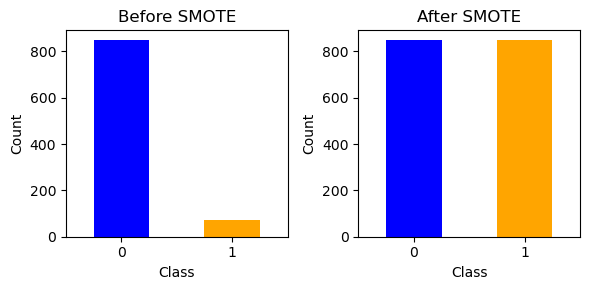

In [8]:
new_class_counts = y_resampled.value_counts()
new_class_counts = new_class_counts.sort_index()

# Visualize change in class imbalance
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
old_class_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Before SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
new_class_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('After SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

### Train/test split

In [9]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, 
                                                    y_resampled, 
                                                    test_size=0.2, 
                                                    random_state=28)

### Exploring a Basic NN

In [10]:
# Define the neural network model
model = Sequential([
    Dense(128, 
          activation='relu', 
          input_shape=(768,),
          kernel_initializer='he_normal', 
          kernel_regularizer=keras.regularizers.l2(0.01)),
    Dropout(0.1),
    Dense(64, 
          activation='relu',
          kernel_initializer='he_normal',
          kernel_regularizer=keras.regularizers.l2(0.01)),
    Dropout(0.1),
    Dense(1, 
          activation='sigmoid',
          kernel_initializer='he_normal',
          kernel_regularizer=keras.regularizers.l2(0.01))
])

2024-02-21 15:24:14.665787: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46262 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:81:00.0, compute capability: 8.6


In [11]:
#opt = tf.keras.optimizers.Adam(learning_rate=0.001, weight_decay=0.01)#, use_ema=True, ema_momentum=0.9)
opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.99, nesterov=True)
#opt = tf.keras.optimizers.Adadelta(learning_rate=0.01, use_ema=True, ema_momentum=0.99)

# Compile the model
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy']) 

In [12]:
# Train the model
history = model.fit(X_train, y_train,
                    epochs=15,
                    batch_size=16,
                    validation_split=0.2)

Epoch 1/15


2024-02-21 15:24:20.954798: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-21 15:24:22.693912: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f6be0b0fbb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-21 15:24:22.693990: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-02-21 15:24:22.710718: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1708547062.791302  815793 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


68/68 [==============================] - 4s 7ms/step - loss: 4.4103 - accuracy: 0.5756 - val_loss: 4.1510 - val_accuracy: 0.6875
Epoch 2/15
68/68 [==============================] - 0s 3ms/step - loss: 3.8824 - accuracy: 0.6577 - val_loss: 3.5377 - val_accuracy: 0.6838
Epoch 3/15
68/68 [==============================] - 0s 3ms/step - loss: 3.2190 - accuracy: 0.7168 - val_loss: 2.8769 - val_accuracy: 0.7243
Epoch 4/15
68/68 [==============================] - 0s 3ms/step - loss: 2.5720 - accuracy: 0.7445 - val_loss: 2.2503 - val_accuracy: 0.8346
Epoch 5/15
68/68 [==============================] - 0s 3ms/step - loss: 1.9940 - accuracy: 0.8192 - val_loss: 1.8006 - val_accuracy: 0.8015
Epoch 6/15
68/68 [==============================] - 0s 3ms/step - loss: 1.5115 - accuracy: 0.8819 - val_loss: 1.3278 - val_accuracy: 0.9081
Epoch 7/15
68/68 [==============================] - 0s 3ms/step - loss: 1.1441 - accuracy: 0.9308 - val_loss: 1.0282 - val_accuracy: 0.9301
Epoch 8/15
68/68 [=============

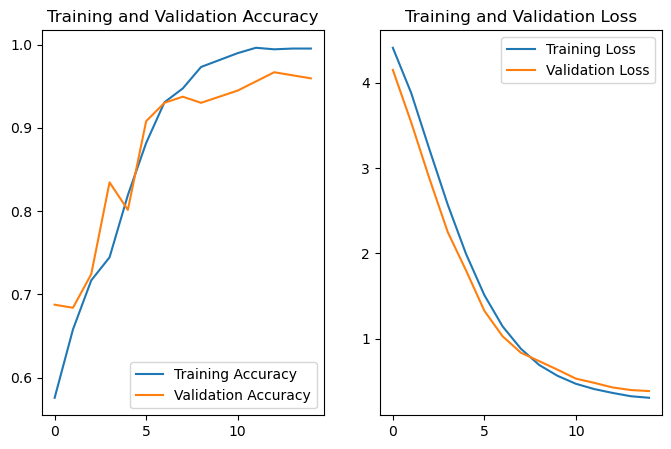

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [14]:
# Predict probs for positive class
y_pred_prob = model.predict(X_test)

# AUC-ROC score
auc_roc = roc_auc_score(y_test, y_pred_prob)

# Convert probs to class labels
y_pred_class = (y_pred_prob > 0.5).astype(int)

# F1-score
f1 = f1_score(y_test, y_pred_class)

print("AUC-ROC Score:", auc_roc)
print("F1-Score:", f1)

11/11 [==============================] - 0s 1ms/step
AUC-ROC Score: 0.9823717948717948
F1-Score: 0.9633507853403142


---

# Comments on model results:

These results possibly indicate that there are discernible patterns in the text of US presidential speeches that correlate with the US entering a major war  within one year of the speech. This (I think) suggests that Presidents leverage certain language or rhetorical cues in their speeches to prepare the nation for war.